In [1]:
!pip install transformers 
!pip install peft
!pip install evaluate
!pip install scikit-learn
!pip install accelerate
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.4 MB/s eta 0:00:00:00:0100:01


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from peft import LoraConfig, get_peft_model, TaskType
import torch

model_name = "allenai/scibert_scivocab_cased"
num_labels = 11

2025-05-19 07:57:54.234632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747641474.435789     206 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747641474.494112     206 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from datasets import load_dataset

dataset = load_dataset("ccdv/arxiv-classification")

In [5]:
labels = [x['label'] for x in dataset['train']]

In [6]:
from collections import Counter

label_counts = Counter(labels)
print(label_counts)

Counter({8: 3527, 7: 2768, 3: 2631, 4: 2599, 10: 2581, 2: 2569, 9: 2560, 0: 2456, 6: 2443, 1: 2137, 5: 2117})


In [7]:
import pandas as pd

df = pd.DataFrame(labels, columns=["label"])
print(df["label"].value_counts(normalize=True).sort_index())

label
0     0.086515
1     0.075278
2     0.090496
3     0.092680
4     0.091553
5     0.074574
6     0.086057
7     0.097506
8     0.124243
9     0.090179
10    0.090919
Name: proportion, dtype: float64


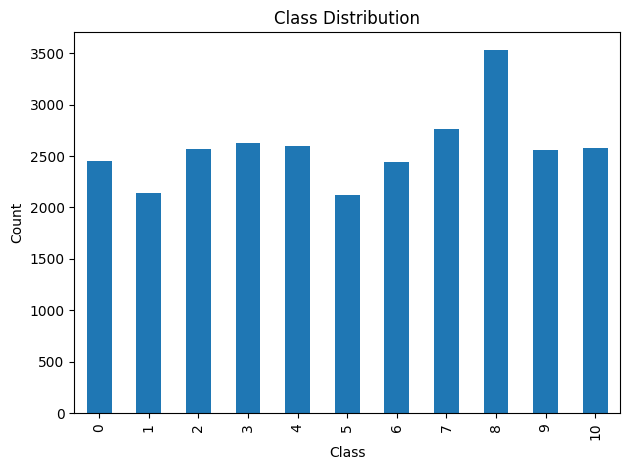

In [8]:
import matplotlib.pyplot as plt

counts = df["label"].value_counts().sort_index()
counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Map:   0%|          | 0/28388 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train'][5]

In [11]:
from transformers import Trainer
from evaluate import load
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Load a metric (F1-score in this case)
metric = load("f1")

# Define a custom compute_metrics function
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall
    }

In [12]:
config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
train_dataset = tokenized_dataset["train"].shuffle(seed=42)
eval_dataset = tokenized_dataset["validation"].shuffle(seed=42)

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [15]:
from transformers import TrainingArguments
import torch
import gc
torch.cuda.empty_cache()

args = TrainingArguments(
    output_dir="./output",
    per_device_eval_batch_size=1,
    do_eval=True,
    logging_dir="./logs",
    fp16=True,
    report_to=[]
    # report_to=["wandb"]    # ✅ enables WandB logging
)

trainer = Trainer(
    model=base_model,
    tokenizer=tokenizer,
    args=args,
    compute_metrics=compute_metrics
)

gc.collect()
torch.cuda.empty_cache()

# Run evaluation
results = trainer.evaluate(eval_dataset)
print(results)

/tmp/ipykernel_206/1727423372.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 2.5555944442749023, 'eval_model_preparation_time': 0.0028, 'eval_accuracy': 0.0988, 'eval_f1_macro': 0.03302179027350315, 'eval_precision_macro': 0.022056273507331057, 'eval_recall_macro': 0.1005983484791602, 'eval_runtime': 52.1083, 'eval_samples_per_second': 47.977, 'eval_steps_per_second': 47.977}


In [16]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "key", "value"],  # типово для BERT-like моделей
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

trainable params: 450,827 || all params: 110,377,750 || trainable%: 0.4084


In [20]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_2",
    eval_strategy="epoch",
    learning_rate=5e-5, 
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs", 
    logging_steps=100,
    fp16=True,
    save_strategy = "epoch",
    report_to = [ ],
    # report_to = ["wandb"],  # ✅ enables WandB logging
    run_name = "workshop"
)

In [19]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 